<h2> 4ppm </h2>
Enough retcor groups, and fewer peak insertion problems than 4.5 or 5ppm.

In [1]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.model_selection import cross_val_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

from scipy import interp

%matplotlib inline

In [2]:
def remove_zero_columns(X, threshold=1e-20):
    # convert zeros to nan, drop all nan columns, the replace leftover nan with zeros
    X_non_zero_colum = X.replace(0, np.nan).dropna(how='all', axis=1).replace(np.nan, 0)
    #.dropna(how='all', axis=0).replace(np.nan,0)
    return X_non_zero_colum

def zero_fill_half_min(X, threshold=1e-20):
    # Fill zeros with 1/2 the minimum value of that column
    # input dataframe. Add only to zero values
    
    # Get a vector of 1/2 minimum values
    half_min = X[X > threshold].min(axis=0)*0.5
    
    # Add the half_min values to a dataframe where everything that isn't zero is NaN.
    # then convert NaN's to 0
    fill_vals = (X[X < threshold] + half_min).fillna(value=0)
    
    # Add the original dataframe to the dataframe of zeros and fill-values
    X_zeros_filled = X + fill_vals
    return X_zeros_filled



toy = pd.DataFrame([[1,2,3,0],
               [0,0,0,0],
               [0.5,1,0,0]], dtype=float)

toy_no_zeros = remove_zero_columns(toy)
toy_filled_zeros = zero_fill_half_min(toy_no_zeros)
print toy
print toy_no_zeros
print toy_filled_zeros

     0  1  2  3
0  1.0  2  3  0
1  0.0  0  0  0
2  0.5  1  0  0
     0  1  2
0  1.0  2  3
1  0.0  0  0
2  0.5  1  0
      0    1    2
0  1.00  2.0  3.0
1  0.25  0.5  1.5
2  0.50  1.0  1.5


<h2> Import the dataframe and remove any features that are all zero </h2>

In [4]:
### Subdivide the data into a feature table
data_path = '/home/irockafe/Dropbox (MIT)/Alm_Lab/projects/revo_healthcare/data/processed/MTBLS315/'\
'uhplc_pos/xcms_result_4.csv'
## Import the data and remove extraneous columns
df = pd.read_csv(data_path, index_col=0)
df.shape
df.head()
# Make a new index of mz:rt
mz = df.loc[:,"mz"].astype('str')
rt = df.loc[:,"rt"].astype('str')
idx = mz+':'+rt
df.index = idx
df
# separate samples from xcms/camera things to make feature table
not_samples = ['mz', 'mzmin', 'mzmax', 'rt', 'rtmin', 'rtmax', 
               'npeaks', 'uhplc_pos', 
               ]
samples_list = df.columns.difference(not_samples)
mz_rt_df = df[not_samples]

# convert to samples x features
X_df_raw = df[samples_list].T
# Remove zero-full columns and fill zeroes with 1/2 minimum values
X_df = remove_zero_columns(X_df_raw)
X_df_zero_filled = zero_fill_half_min(X_df)

print "original shape: %s \n# zeros: %f\n" % (X_df_raw.shape, (X_df_raw < 1e-20).sum().sum())
print "zero-columns repalced? shape: %s \n# zeros: %f\n" % (X_df.shape, 
                                                         (X_df < 1e-20).sum().sum())
print "zeros filled shape: %s \n#zeros: %f\n" % (X_df_zero_filled.shape, 
                                              (X_df_zero_filled < 1e-20).sum().sum())


# Convert to numpy matrix to play nicely with sklearn
X = X_df.as_matrix()
print X.shape


original shape: (61, 6737) 
# zeros: 3727.000000

zero-columns repalced? shape: (61, 6737) 
# zeros: 3727.000000

zeros filled shape: (61, 6737) 
#zeros: 0.000000

(61, 6737)


<h2> Get mappings between sample names, file names, and sample classes </h2>

In [5]:
# Get mapping between sample name and assay names
path_sample_name_map = '/home/irockafe/Dropbox (MIT)/Alm_Lab/projects/revo_healthcare/data/raw/'\
                'MTBLS315/metadata/a_UPLC_POS_nmfi_and_bsi_diagnosis.txt'
# Index is the sample name
sample_df = pd.read_csv(path_sample_name_map, 
                        sep='\t', index_col=0)
sample_df = sample_df['MS Assay Name']
sample_df.shape
print sample_df.head(10)

# get mapping between sample name and sample class
path_sample_class_map = '/home/irockafe/Dropbox (MIT)/Alm_Lab/projects/revo_healthcare/data/raw/'\
                        'MTBLS315/metadata/s_NMFI and BSI diagnosis.txt'
class_df = pd.read_csv(path_sample_class_map,
                      sep='\t')
# Set index as sample name
class_df.set_index('Sample Name', inplace=True)
class_df = class_df['Factor Value[patient group]']
print class_df.head(10)

# convert all non-malarial classes into a single classes 
# (collapse non-malarial febril illness and bacteremia together)
class_map_df = pd.concat([sample_df, class_df], axis=1)
class_map_df.rename(columns={'Factor Value[patient group]': 'class'}, inplace=True)
class_map_df

binary_class_map = class_map_df.replace(to_replace=['non-malarial febrile illness', 'bacterial bloodstream infection' ], 
                                        value='non-malarial fever')

binary_class_map


Sample Name
MCMA429    1001_P
MCMA430    1002_P
MCMA431    1003_P
MCMA433    1004_P
MCMA434    1005_P
MCMA435    1006_P
MCMA436    1007_P
MCMA442    1009_P
MCMA443    1010_P
MCMA444    1011_P
Name: MS Assay Name, dtype: object
Sample Name
MCMA429                            malaria
MCMA430                            malaria
MCMA431                            malaria
MCMA433                            malaria
MCMA434       non-malarial febrile illness
MCMA435                            malaria
MCMA436    bacterial bloodstream infection
MCMA442                            malaria
MCMA443       non-malarial febrile illness
MCMA444    bacterial bloodstream infection
Name: Factor Value[patient group], dtype: object


,MS Assay Name,class
Sample Name,,
MCMA429,1001_P,malaria
MCMA430,1002_P,malaria
MCMA431,1003_P,malaria
MCMA433,1004_P,malaria
MCMA434,1005_P,non-malarial fever
MCMA435,1006_P,malaria
MCMA436,1007_P,non-malarial fever
MCMA442,1009_P,malaria
MCMA443,1010_P,non-malarial fever


In [6]:
# convert classes to numbers
le = preprocessing.LabelEncoder()
le.fit(binary_class_map['class'])
y = le.transform(binary_class_map['class'])

<h2> Plot the distribution of classification accuracy across multiple cross-validation splits - Kinda Dumb</h2>
Turns out doing this is kind of dumb, because you're not taking into account the prediction score your classifier assigned. Use AUC's instead. You want to give your classifier a lower score if it is really confident and wrong, than vice-versa

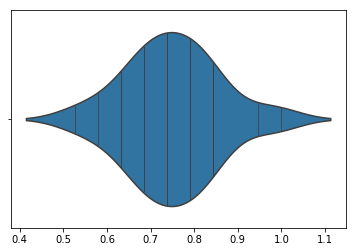

In [48]:
def rf_violinplot(X, y, n_iter=25, test_size=0.3, random_state=1,
                 n_estimators=1000):
    cross_val_skf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, 
                                           random_state=random_state)
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    scores = cross_val_score(clf, X, y, cv=cross_val_skf)

    sns.violinplot(scores,inner='stick')

rf_violinplot(X,y)


# TODO - Switch to using caret for this bs..?

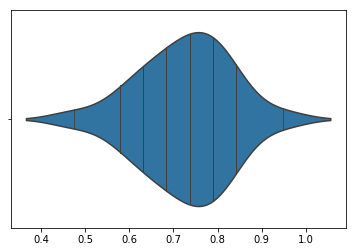

In [49]:
# Do multi-fold cross validation for adaboost classifier
def adaboost_violinplot(X, y, n_iter=25, test_size=0.3, random_state=1,
                       n_estimators=200):
    cross_val_skf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
    clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=random_state)

    scores = cross_val_score(clf, X, y, cv=cross_val_skf)

    sns.violinplot(scores,inner='stick')

adaboost_violinplot(X,y)

[[  1.   1.   1.]
 [  2.   2.   2.]
 [  3.   6.   9.]
 [  6.  12.  18.]]
[[  1.   1.   1.   2.   2.   2.   3.   6.   9.   6.  12.  18.]]
allquotients reshaped!

(3,)


/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


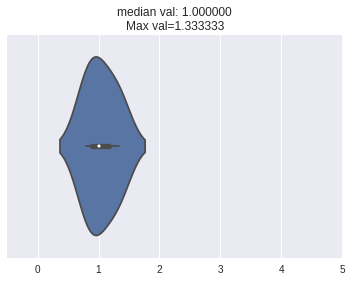

allquotients reshaped!

(3,)


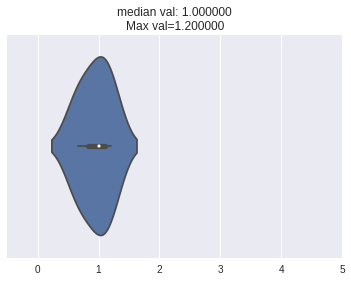

allquotients reshaped!

(3,)


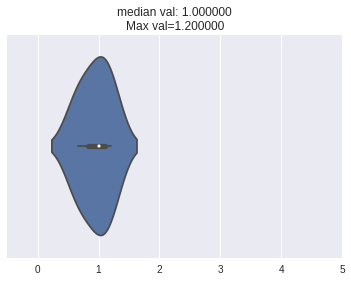

[[ 0.33333333  0.33333333  0.33333333]
 [ 0.33333333  0.33333333  0.33333333]
 [ 0.16666667  0.33333333  0.5       ]
 [ 0.16666667  0.33333333  0.5       ]]




[[ 4.  4.  4.]
 [ 4.  4.  4.]
 [ 2.  4.  6.]
 [ 2.  4.  6.]]


In [7]:
# TODO PQN normalization, and log-transformation, 
# and some feature selection (above certain threshold of intensity, use principal components), et

def pqn_normalize(X, integral_first=False, plot=False):
    '''
    Take a feature table and run PQN normalization on it
    '''
    # normalize by sum of intensities in each sample first. Not necessary
    if integral_first: 
        sample_sums = np.sum(X, axis=1)
        X = (X / sample_sums[:,np.newaxis])
    
    # Get the median value of each feature across all samples
    mean_intensities = np.median(X, axis=0)
    
    # Divde each feature by the median value of each feature - 
    # these are the quotients for each feature
    X_quotients = (X / mean_intensities[np.newaxis,:])
    
    if plot: # plot the distribution of quotients from one sample
        for i in range(1,len(X_quotients[:,1])):
            print 'allquotients reshaped!\n\n', 
            #all_quotients = X_quotients.reshape(np.prod(X_quotients.shape))
            all_quotients = X_quotients[i,:]
            print all_quotients.shape
            x = np.random.normal(loc=0, scale=1, size=len(all_quotients))
            sns.violinplot(all_quotients)
            plt.title("median val: %f\nMax val=%f" % (np.median(all_quotients), np.max(all_quotients)))
            plt.plot( title="median val: ")#%f" % np.median(all_quotients))
            plt.xlim([-0.5, 5])
            plt.show()

    # Define a quotient for each sample as the median of the feature-specific quotients
    # in that sample
    sample_quotients = np.median(X_quotients, axis=1)
    
    # Quotient normalize each samples
    X_pqn = X / sample_quotients[:,np.newaxis]
    return X_pqn

# Make a fake sample, with 2 samples at 1x and 2x dilutions
X_toy = np.array([[1,1,1,],
                  [2,2,2],
                  [3,6,9],
                  [6,12,18]], dtype=float)
print X_toy
print X_toy.reshape(1, np.prod(X_toy.shape))
X_toy_pqn_int = pqn_normalize(X_toy, integral_first=True, plot=True)
print X_toy_pqn_int

print '\n\n\n'
X_toy_pqn = pqn_normalize(X_toy)
print X_toy_pqn

<h2> pqn normalize your features </h2>

In [8]:
X_pqn = pqn_normalize(X)
print X_pqn

[[ 8061763.45442697   975281.90381542   133695.11953594 ...,
    162720.55292404    66059.89236761        0.        ]
 [  224720.32343911   673341.75850962    91456.24020969 ...,
    154850.01461104    45478.6122859         0.        ]
 [ 5826843.98077533   597801.87658097   102430.89994654 ...,
   2247213.65614013   644294.60717892   131227.57183839]
 ..., 
 [   81568.4510014    352216.26982313    47480.89219749 ...,
   3497642.22558858   974090.59581113   193928.06594746]
 [ 5294065.04849177   546902.33902973    80730.80459947 ...,
   2331238.17876363   700689.9491294    142370.83585623]
 [ 5064316.7543952    549299.2832155    537743.13854891 ...,
   7821752.61121714  2093480.91178183   432474.30550998]]


<h2>Random Forest & adaBoost with PQN-normalized data</h2>

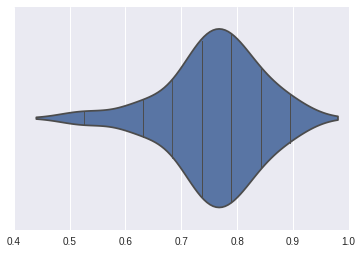

In [231]:
rf_violinplot(X_pqn, y)

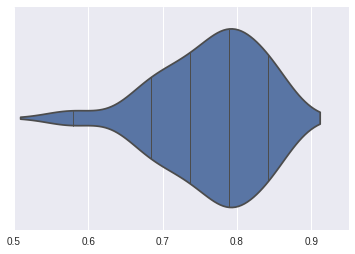

In [232]:
# Do multi-fold cross validation for adaboost classifier
adaboost_violinplot(X_pqn, y)

<h2> RF & adaBoost with PQN-normalized, log-transformed data </h2>
Turns out a monotonic transformation doesn't really affect any of these things. 
I guess they're already close to unit varinace...?

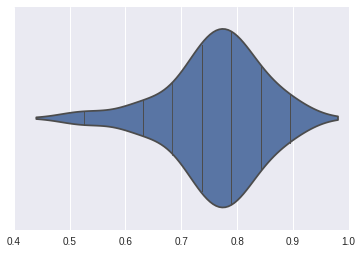

In [234]:
X_pqn_nlog = np.log(X_pqn)
rf_violinplot(X_pqn_nlog, y)

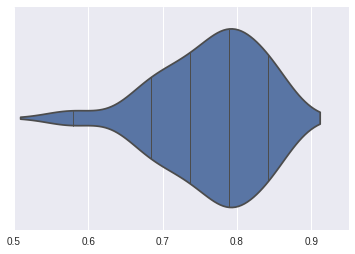

In [235]:
adaboost_violinplot(X_pqn_nlog, y)

In [9]:
def roc_curve_cv(X, y, clf, cross_val,
                path='/home/irockafe/Desktop/roc.pdf',
                save=False, plot=True):  
    t1 = time.time()
    # collect vals for the ROC curves
    tpr_list = []
    mean_fpr = np.linspace(0,1,100)
    auc_list = []
    
    # Get the false-positive and true-positive rate
    for i, (train, test) in enumerate(cross_val):
        clf.fit(X[train], y[train])
        y_pred = clf.predict_proba(X[test])[:,1]
        
        # get fpr, tpr
        fpr, tpr, thresholds = roc_curve(y[test], y_pred)
        roc_auc = auc(fpr, tpr)
        #print 'AUC', roc_auc
        #sns.plt.plot(fpr, tpr, lw=10, alpha=0.6, label='ROC - AUC = %0.2f' % roc_auc,)
        #sns.plt.show()
        tpr_list.append(interp(mean_fpr, fpr, tpr))
        tpr_list[-1][0] = 0.0
        auc_list.append(roc_auc)
        
        if (i % 10 == 0):
            print '{perc}% done! {time}s elapsed'.format(perc=100*float(i)/cross_val.n_iter, time=(time.time() - t1))
        
            
        
        
    # get mean tpr and fpr
    mean_tpr = np.mean(tpr_list, axis=0)
    # make sure it ends up at 1.0
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(auc_list)
    
    if plot:
        # plot mean auc
        plt.plot(mean_fpr, mean_tpr, label='Mean ROC - AUC = %0.2f $\pm$ %0.2f' % (mean_auc, 
                                                                                       std_auc),
                    lw=5, color='b')

        # plot luck-line
        plt.plot([0,1], [0,1], linestyle = '--', lw=2, color='r',
                    label='Luck', alpha=0.5) 

        # plot 1-std
        std_tpr = np.std(tpr_list, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                            label=r'$\pm$ 1 stdev')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve, {iters} iterations of {cv} cross validation'.format(
            iters=cross_val.n_iter, cv='{train}:{test}'.format(test=cross_val.test_size, train=(1-cross_val.test_size)))
                 )
        plt.legend(loc="lower right")

        if save:
            plt.savefig(path,  format='pdf')


        plt.show()
    return tpr_list, auc_list, mean_fpr

3
0.3
0.0% done! 2.89502501488s elapsed


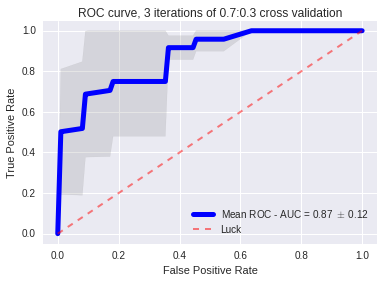

In [10]:


rf_estimators = 1000
n_iter = 3
test_size = 0.3
random_state = 1
cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf_rf = RandomForestClassifier(n_estimators=rf_estimators, random_state=random_state)
rf_graph_path = '''/home/irockafe/Dropbox (MIT)/Alm_Lab/projects/revolutionizing_healthcare/data/MTBLS315/\
isaac_feature_tables/uhplc_pos/rf_roc_{trees}trees_{cv}cviter.pdf'''.format(trees=rf_estimators, cv=n_iter)

print cross_val_rf.n_iter
print cross_val_rf.test_size

tpr_vals, auc_vals, mean_fpr = roc_curve_cv(X_pqn, y, clf_rf, cross_val_rf,
                                           path=rf_graph_path, save=False)

0.0% done! 4.92638397217s elapsed


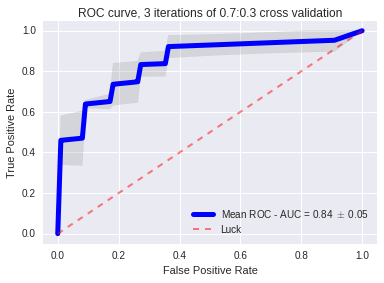

In [11]:
# For adaboosted
n_iter = 3
test_size = 0.3
random_state = 1
adaboost_estimators = 200
adaboost_path = '''/home/irockafe/Dropbox (MIT)/Alm_Lab/projects/revolutionizing_healthcare/data/MTBLS315/\
isaac_feature_tables/uhplc_pos/adaboost_roc_{trees}trees_{cv}cviter.pdf'''.format(trees=adaboost_estimators, 
                                                                            cv=n_iter)


cross_val_adaboost = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf = AdaBoostClassifier(n_estimators=adaboost_estimators, random_state=random_state)
adaboost_tpr, adaboost_auc, adaboost_fpr = roc_curve_cv(X_pqn, y, clf, cross_val_adaboost,
                                                       path=adaboost_path)

<h2> Great, you can classify things. But make null models and do a sanity check to make 
sure you arent just classifying garbage </h2>

In [16]:
# Make a null model AUC curve

def make_null_model(X, y, clf, cross_val, random_state=1, num_shuffles=5, plot=True):
    '''
    Runs the true model, then sanity-checks by:
    
    Shuffles class labels and then builds cross-validated ROC curves from them.
    Compares true AUC vs. shuffled auc by t-test (assumes normality of AUC curve)
    '''
    null_aucs = []
    print y.shape
    print X.shape
    tpr_true, auc_true, fpr_true = roc_curve_cv(X, y, clf, cross_val)
    # shuffle y lots of times
    for i in range(0, num_shuffles):
        #Iterate through the shuffled y vals and repeat with appropriate params
        # Retain the auc vals for final plotting of distribution
        y_shuffle = shuffle(y)
        cross_val.y = y_shuffle
        cross_val.y_indices = y_shuffle
        print 'Number of differences b/t original and shuffle: %s' % (y == cross_val.y).sum()
        # Get auc values for number of iterations
        tpr, auc, fpr = roc_curve_cv(X, y_shuffle, clf, cross_val, plot=False)
        
        null_aucs.append(auc)
    
    
    #plot the outcome
    if plot:
        flattened_aucs = [j for i in null_aucs for j in i]
        my_dict = {'true_auc': auc_true, 'null_auc': flattened_aucs}
        df_poop =  pd.DataFrame.from_dict(my_dict, orient='index').T
        df_tidy = pd.melt(df_poop, value_vars=['true_auc', 'null_auc'],
                         value_name='auc', var_name='AUC_type')
        #print flattened_aucs
        sns.violinplot(x='AUC_type', y='auc',
            inner='points', data=df_tidy)
        # Plot distribution of AUC vals   
        plt.title("Distribution of aucs")
        #sns.plt.ylabel('count')
        plt.xlabel('AUC')
        #sns.plt.plot(auc_true, 0, color='red', markersize=10)
        plt.show()
    # Do a quick t-test to see if odds of randomly getting an AUC that good
    return auc_true, null_aucs


(61,)
(61, 6737)
0.0% done! 2.17478203773s elapsed
20.0% done! 23.3973300457s elapsed
40.0% done! 46.2013208866s elapsed
60.0% done! 68.2610578537s elapsed
80.0% done! 88.2748949528s elapsed


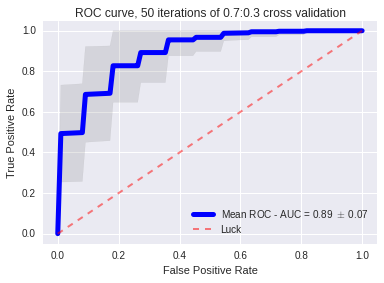

Number of differences b/t original and shuffle: 35
0.0% done! 2.02961707115s elapsed
20.0% done! 22.3963952065s elapsed
40.0% done! 42.791118145s elapsed
60.0% done! 63.2403421402s elapsed
80.0% done! 84.0973091125s elapsed
Number of differences b/t original and shuffle: 35
0.0% done! 2.01401996613s elapsed
20.0% done! 22.2009749413s elapsed
40.0% done! 42.898570776s elapsed
60.0% done! 63.5395178795s elapsed
80.0% done! 83.9713997841s elapsed
Number of differences b/t original and shuffle: 35
0.0% done! 2.01662707329s elapsed
20.0% done! 22.370141983s elapsed
40.0% done! 43.4918119907s elapsed
60.0% done! 64.6998240948s elapsed
80.0% done! 84.951884985s elapsed
Number of differences b/t original and shuffle: 35
0.0% done! 2.21932697296s elapsed
20.0% done! 25.2558701038s elapsed
40.0% done! 46.1843161583s elapsed
60.0% done! 68.6732871532s elapsed
80.0% done! 91.1767549515s elapsed
Number of differences b/t original and shuffle: 31
0.0% done! 2.6047000885s elapsed
20.0% done! 26.79529

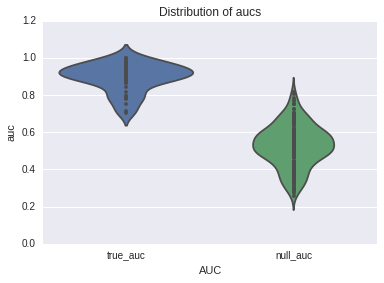

In [17]:
# Make a null model AUC curve & compare it to null-model

# Random forest magic!
rf_estimators = 1000
n_iter = 50
test_size = 0.3
random_state = 1
cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf_rf = RandomForestClassifier(n_estimators=rf_estimators, random_state=random_state)

true_auc, all_aucs = make_null_model(X_pqn, y, clf_rf, cross_val_rf, num_shuffles=5)

   AUC_type       auc
0  true_auc  0.886364
1  true_auc  0.943182
2  true_auc  0.681818
3  true_auc  0.795455
4  true_auc  0.886364


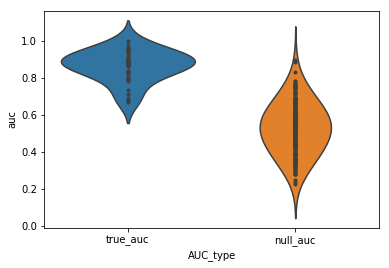

In [76]:
# make dataframe from true and false aucs
flattened_aucs = [j for i in all_aucs for j in i]
my_dict = {'true_auc': true_auc, 'null_auc': flattened_aucs}
df_poop =  pd.DataFrame.from_dict(my_dict, orient='index').T
df_tidy = pd.melt(df_poop, value_vars=['true_auc', 'null_auc'],
                 value_name='auc', var_name='AUC_type')
print df_tidy.head()
#print flattened_aucs
sns.violinplot(x='AUC_type', y='auc',
    inner='points', data=df_tidy, bw=0.7)
plt.show()



<h2> Let's check out some PCA plots </h2>

[('red', 0, 'malaria'), ('blue', 1, 'non-malaria fever')]
(34,)
(27,)


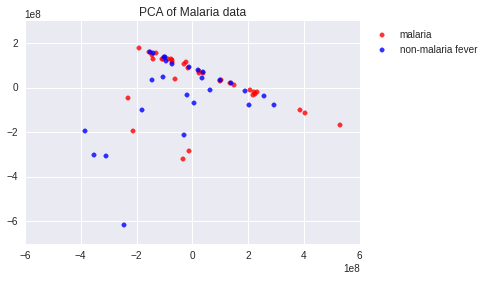

[('red', 0, 'malaria'), ('blue', 1, 'non-malaria fever')]
(34,)
(27,)


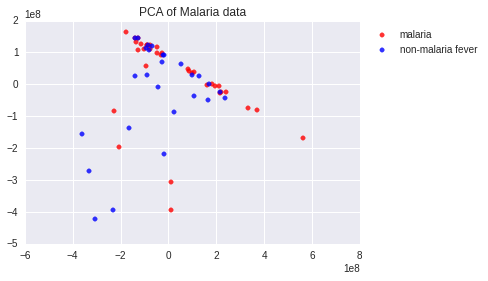

In [14]:
from sklearn.decomposition import PCA

# Check PCA of things
def PCA_plot(X, y, n_components, plot_color, class_nums, class_names, title='PCA'):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit(X).transform(X)

    print zip(plot_color, class_nums, class_names)
    for color, i, target_name in zip(plot_color, class_nums, class_names):
        
        # plot one class at a time, first plot all classes y == 0
        #print color
        #print y == i
        xvals = X_pca[y == i, 0]
        print xvals.shape
        yvals = X_pca[y == i, 1]
        plt.scatter(xvals, yvals, color=color, alpha=0.8, label=target_name)

    plt.legend(bbox_to_anchor=(1.01,1), loc='upper left', shadow=False)#, scatterpoints=1)
    plt.title('PCA of Malaria data')
    plt.show()


PCA_plot(X_pqn, y, 2, ['red', 'blue'], [0,1], ['malaria', 'non-malaria fever'])
PCA_plot(X, y, 2, ['red', 'blue'], [0,1], ['malaria', 'non-malaria fever'])

<h2> What about with all thre classes? </h2>

            MS Assay Name                            class
Sample Name                                               
MCMA429            1001_P                          malaria
MCMA430            1002_P                          malaria
MCMA431            1003_P                          malaria
MCMA433            1004_P                          malaria
MCMA434            1005_P     non-malarial febrile illness
MCMA435            1006_P                          malaria
MCMA436            1007_P  bacterial bloodstream infection
MCMA442            1009_P                          malaria
MCMA443            1010_P     non-malarial febrile illness
MCMA444            1011_P  bacterial bloodstream infection
[1 1 1 1 2 1 0 1 2 0 0 1 1 1 1 1 0 2 2 2 2 0 1 1 1 1 2 0 2 1 2 1 1 1 1 1 1
 2 1 0 1 1 0 0 1 2 0 2 2 1 0 1 1 2 0 2 1 1 1 1 1]
(61, 6737)
(61,)
['bacterial bloodstream infection' 'malaria' 'non-malarial febrile illness']
[0 1 2]
[('green', 0, 'bacterial bloodstream infection'), ('red', 1, 'mal

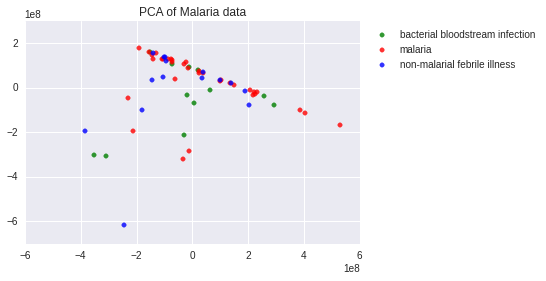

[('green', 0, 'bacterial bloodstream infection'), ('red', 1, 'malaria'), ('blue', 2, 'non-malarial febrile illness')]
(12,)
(34,)
(15,)


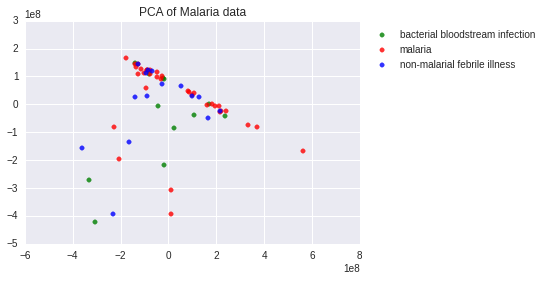

In [15]:
# convert classes to numbers
le = preprocessing.LabelEncoder()
le.fit(class_map_df['class'])
y_three_class = le.transform(class_map_df['class'])
print class_map_df.head(10)
print y_three_class
print X.shape
print y_three_class.shape

y_labels = np.sort(class_map_df['class'].unique())
print y_labels
colors = ['green', 'red', 'blue']

print np.unique(y_three_class)
PCA_plot(X_pqn, y_three_class, 2, colors, np.unique(y_three_class), y_labels)
PCA_plot(X, y_three_class, 2, colors, np.unique(y_three_class), y_labels)
